In [1]:
import sys
sys.path.insert(0, '/Users/gil-arnaudcoche/Documents/ijoutaku/')

import time
import keras
import matplotlib.pyplot as plt


from config.paths import TRAIN_PATH
from config.paths import MODELS_PATH

from config.models import EPOCHS

from config.models import LSTM_FILTERS_1
from config.models import LSTM_FILTERS_2
from config.models import LSTM_FILTERS_3
from config.models import LSTM_KERNEL

from config.models import PADDING
from config.models import SIGMOID
from config.models import RELU
from config.models import LOSS
from config.models import LEARNING_RATE
from config.models import EPSILON


from lib.generators import ForwardDataGenerator

In [2]:
train_set = ForwardDataGenerator(TRAIN_PATH, shuffle_at_start=True)

In [3]:
model = keras.models.Sequential()
# Input layer
model.add(keras.layers.Input(batch_shape=(ForwardDataGenerator._BATCH_SIZE, ForwardDataGenerator._LOOKBACK, ForwardDataGenerator._IMAGE_HEIGHT, ForwardDataGenerator._IMAGE_WIDTH, 1)))
# Encoder
model.add(keras.layers.ConvLSTM2D(filters=LSTM_FILTERS_1, kernel_size=LSTM_KERNEL, padding=PADDING, return_sequences=True, activation=RELU))
model.add(keras.layers.ConvLSTM2D(filters=LSTM_FILTERS_2, kernel_size=LSTM_KERNEL, padding=PADDING, return_sequences=True, activation=RELU))
model.add(keras.layers.ConvLSTM2D(filters=LSTM_FILTERS_3, kernel_size=LSTM_KERNEL, padding=PADDING, return_sequences=False, activation=RELU))
# Decoder
model.add(keras.layers.Reshape((1, ForwardDataGenerator._IMAGE_HEIGHT, ForwardDataGenerator._IMAGE_WIDTH, LSTM_FILTERS_3)))
model.add(keras.layers.ConvLSTM2D(filters=LSTM_FILTERS_2, kernel_size=LSTM_KERNEL, padding=PADDING, return_sequences=True, activation=RELU))
model.add(keras.layers.ConvLSTM2D(filters=LSTM_FILTERS_1, kernel_size=LSTM_KERNEL, padding=PADDING, return_sequences=False, activation=RELU))
model.add(keras.layers.Conv2DTranspose(filters=1, kernel_size=LSTM_KERNEL, padding=PADDING, activation=SIGMOID))
print(model.summary())
model.compile(loss=LOSS, optimizer=keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE, epsilon=EPSILON))
start = time.time()
history = model.fit(train_set, batch_size=ForwardDataGenerator._BATCH_SIZE, epochs=EPOCHS, shuffle=True)
end = time.time()
duration_seconds = int(end - start)
duration_minutes, leftover_seconds = duration_seconds // 60, duration_seconds % 60
print(f'Training took {duration_minutes} min {leftover_seconds} s')
model.save(f'{MODELS_PATH}lstm-autoencoder-forward.hdf5')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (3, 5, 88, 128, 16)       9856      
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (3, 5, 88, 128, 8)        6944      
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (3, 88, 128, 4)           1744      
                                                                 
 reshape (Reshape)           (3, 1, 88, 128, 4)        0         
                                                                 
 conv_lstm2d_3 (ConvLSTM2D)  (3, 1, 88, 128, 8)        3488      
                                                                 
 conv_lstm2d_4 (ConvLSTM2D)  (3, 88, 128, 16)          13888     
                                                                 
 conv2d_transpose (Conv2DTr  (3, 88, 128, 1)           1

/Users/gil-arnaudcoche/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


dict_keys(['loss'])


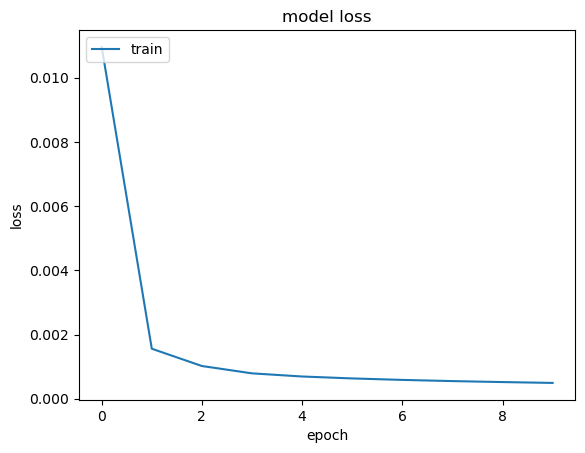

In [4]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()